In [1]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from IPython.core.display import display

from tqdm import tqdm

%matplotlib inline

In [2]:
start_date = datetime.datetime(2000, 10, 1)
end_date = datetime.datetime(2019, 10, 1)
aapl = pdr.get_data_yahoo('AAPL', start=start_date, end=end_date)


In [3]:
aapl.head()

High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2000-10-02  1.910714  1.678571  1.906250  1.732143  606197200.0   1.511664
2000-10-03  1.785714  1.584821  1.781250  1.593750  509530000.0   1.390887
2000-10-04  1.696429  1.562500  1.598214  1.687500  366506000.0   1.472704
2000-10-05  1.750000  1.571429  1.678571  1.575893  218251600.0   1.375302
2000-10-06  1.638393  1.500000  1.620536  1.584821  153164200.0   1.383095

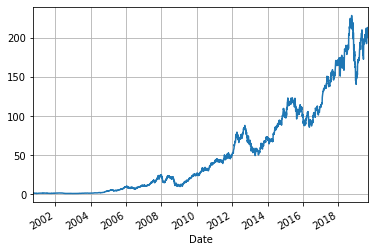

In [5]:
aapl['Adj Close'].plot(grid = True)

In [6]:
# short moving window rolling mean
aapl['fast'] = aapl['Adj Close'].rolling(window=5).mean()
# short moving window rolling mean
aapl['slow'] = aapl['Adj Close'].rolling(window=10).mean()

In [7]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[crit1 & crit2]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[crit1 & crit2]

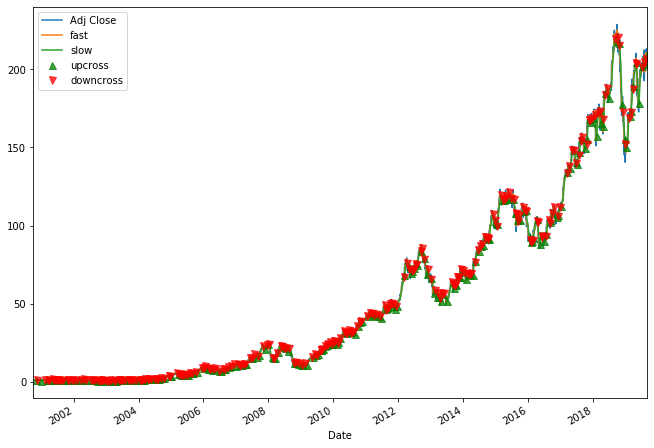

In [8]:
up = get_up_cross(aapl)
down = get_down_cross(aapl)

f, ax = plt.subplots(figsize=(11, 8))

# plot the adjusted closing price, the short and long windows of rolling
aapl[['Adj Close', 'fast', 'slow']].plot(ax=ax, grid=True)

up.plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()


In [12]:
display(len(up.index), len(down.index))

244

243

In [14]:
# Create labels
side_up = pd.Series(1, index=up.index).dropna()
side_down = pd.Series(-1, index=down.index).dropna()
side = pd.concat([side_up, side_down]).sort_index()
display(side[:5], side.shape)

Date
2000-11-01    1
2000-11-10   -1
2000-12-27    1
2001-02-07   -1
2001-03-02    1
dtype: int64

(487,)

In [15]:
crossEvents = side.index
crossEvents[:5]

DatetimeIndex(['2000-11-01', '2000-11-10', '2000-12-27', '2001-02-07',
               '2001-03-02'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [16]:
adj_close = aapl['Adj Close']
adj_close[:5]

Date
2000-10-02    1.511664
2000-10-03    1.390887
2000-10-04    1.472704
2000-10-05    1.375302
2000-10-06    1.383095
Name: Adj Close, dtype: float64

In [17]:
def metaLabling(close, startEvents, side, verticalBarrier = None, SL = None, TP = None):
    if verticalBarrier is None:
        verticalBarrier = pd.Series(close.index[-1], index=startEvents)
    
    if TP is None:
        TP = 10.0
        
    if SL is None:
        SL = 10.0
        
    ret = pd.DataFrame(columns=['touch_tp', 'raw_return', 'p_return', 'side'], index = startEvents)
    t_touch = 0
    r_ret = 0
    p_ret = 0
    
    for t0 in tqdm(startEvents):
        window = close[t0:verticalBarrier[t0]]
        
        if (side[t0] == 1):
            trgHi = close[t0] * TP
            trgLow = close[t0] * SL
        
        fabove = window >= (trgHi + close[t0])
        fbelow = window <= (close[t0] - trgLow)
        
        hiTouch = window[fabove].index.min()
        lowTouch = window[fbelow].index.min()
        
        # print('ht', hiTouch)
        # print('lt', lowTouch)
        
        if pd.isnull(hiTouch) and pd.isnull(lowTouch):
            # display('vertical barrier or infinit')
            t_touch = 0
            r_ret = close[verticalBarrier[t0]]
        elif pd.isnull(hiTouch) and (not pd.isnull(lowTouch)):
            #display('low touch')
            t_touch = -1 
            r_ret = close[lowTouch]
        elif not pd.isnull(hiTouch) and (pd.isnull(lowTouch)):
            #display('hi touch')
            t_touch = 1 
            r_ret = close[hiTouch]
        elif hiTouch < lowTouch:
            #display('HI')
            t_touch = 1
            r_ret = close[hiTouch]
        else:
           # display('LOW')
            t_touch = -1
            r_ret = close[lowTouch]
            
        ret.loc[t0].touch_tp = t_touch * side[t0]
        ret.loc[t0].raw_return = abs(r_ret - close[t0]) * ret.loc[t0].touch_tp
        ret.loc[t0].p_return = abs(r_ret / close[t0] - 1 ) * ret.loc[t0].touch_tp
        ret.loc[t0].side = side[t0]
        
    return ret

In [20]:
df_met = metaLabling(adj_close, crossEvents, side, None, 0.010, 0.015)
df_met.head(10)

100%|██████████| 487/487 [00:02<00:00, 185.19it/s]


touch_tp raw_return   p_return side
Date                                          
2000-11-01        1   0.112985  0.0884147    1
2000-11-10       -1 -0.0194805 -0.0163937   -1
2000-12-27        1  0.0974008   0.105485    1
2001-02-07        1   0.101297   0.078313   -1
2001-03-02        1  0.0701286  0.0584414    1
2001-03-14        1  0.0467522   0.036697   -1
2001-03-21        1  0.0935049  0.0745341    1
2001-04-03        1  0.0461287   0.036561   -1
2001-04-12       -1 -0.0610901 -0.0437111    1
2001-05-08        1  0.0367788  0.0240131   -1

In [21]:
aapl_f = pd.merge(aapl, df_met, left_index=True, right_index=True)
aapl_f.head()

High       Low      Open     Close       Volume  Adj Close  \
Date                                                                         
2000-11-01  1.491071  1.388393  1.388393  1.464286  143841600.0   1.277901   
2000-11-10  1.419643  1.361607  1.382812  1.361607  105562800.0   1.188292   
2000-12-27  1.058036  1.013393  1.024554  1.058036   81366600.0   0.923362   
2001-02-07  1.491071  1.415179  1.475446  1.482143   98471800.0   1.293485   
2001-03-02  1.459821  1.303571  1.308036  1.375000  101550400.0   1.199981   

                fast      slow touch_tp raw_return   p_return side  
Date                                                                
2000-11-01  1.202318  1.200760        1   0.112985  0.0884147    1  
2000-11-10  1.272447  1.284135       -1 -0.0194805 -0.0163937   -1  
2000-12-27  0.909336  0.901934        1  0.0974008   0.105485    1  
2001-02-07  1.294265  1.298940        1   0.101297   0.078313   -1  
2001-03-02  1.185955  1.177773        1  0.0701286  0.0584414    1

In [22]:
display("before:", aapl_f.touch_tp.value_counts())
f = aapl_f.raw_return < 0.10
aapl_f.loc[f,'touch_tp'] = 0
f = aapl_f.touch_tp == -1
aapl_f.loc[f,'touch_tp'] = 0
aapl_f[f].head()
display("after:", aapl_f.touch_tp.value_counts())

'before:'

 1    248
-1    238
 0      1
Name: touch_tp, dtype: int64

'after:'

0    297
1    190
Name: touch_tp, dtype: int64

In [23]:
X = aapl_f[['Volume', 'Adj Close', 'fast', 'slow', 'side']]
y = aapl_f.touch_tp
X.shape

(487, 5)


### TensorFlow Model

In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals

try: 
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(3)

tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\martin\\Anaconda3\\envs\\tf20\\lib\\site-packages\\tensorflow_core\\_api\\v2\\version\\__init__.py'>

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xs = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, np.array(y), test_size=0.05, random_state=42, shuffle=False)



In [26]:
inputs = keras.Input(shape=(5,), name='input')
x = layers.Dense(5, activation='relu', name='dense_1')(inputs)
x = layers.Dense(10, activation='relu', name='dense_2')(x)
outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='3_layer_mlp')
model.summary()

Model: "3_layer_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
predictions (Dense)          (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=10)

Train on 462 samples
Epoch 1/10
462/462 [==============================] - 0s 145us/sample - loss: 0.2082 - accuracy: 0.6212
Epoch 2/10
462/462 [==============================] - 0s 117us/sample - loss: 0.2074 - accuracy: 0.6234
Epoch 3/10
462/462 [==============================] - 0s 145us/sample - loss: 0.2067 - accuracy: 0.6255
Epoch 4/10
462/462 [==============================] - 0s 184us/sample - loss: 0.2059 - accuracy: 0.6320
Epoch 5/10
462/462 [==============================] - 0s 113us/sample - loss: 0.2054 - accuracy: 0.6364
Epoch 6/10
462/462 [==============================] - 0s 81us/sample - loss: 0.2050 - accuracy: 0.6429
Epoch 7/10
462/462 [==============================] - 0s 153us/sample - loss: 0.2044 - accuracy: 0.6450
Epoch 8/10
462/462 [==============================] - 0s 121us/sample - loss: 0.2040 - accuracy: 0.6472
Epoch 9/10
462/462 [==============================] - 0s 199us/sample - loss: 0.2037 - accuracy: 0.6515
Epoch 10/10
462/462 [=======================

In [30]:
model.evaluate(X_test, y_test)

25/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 0.2529 - accuracy: 0.4400


[0.25293344259262085, 0.44]

In [32]:
predictions = model.predict(X_test)
predictions

array([[0.52859956],
       [0.52859956],
       [0.52859956],
       [0.52859956],
       [0.52859956],
       [0.5205689 ],
       [0.52859956],
       [0.51165575],
       [0.52786195],
       [0.49696177],
       [0.52796346],
       [0.5007264 ],
       [0.52859956],
       [0.51123434],
       [0.52859956],
       [0.52859956],
       [0.52859956],
       [0.52723837],
       [0.52859956],
       [0.52784294],
       [0.52859956],
       [0.5260322 ],
       [0.52859956],
       [0.52859956],
       [0.52859956]], dtype=float32)

In [33]:
# Save the model
model.save('C:\\tmp\\labeling.h5')

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('C:\\tmp\\labeling.h5')

In [34]:
# check that the state is preserved
new_predictions = new_model.predict(X_test)
print(np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6))

None


In [35]:
inputs = keras.Input(shape=(5,), name='input')
x = layers.Dense(5, activation='relu', name='dense_1')(inputs)
x = layers.Dense(10, activation='relu', name='dense_2')(x)
x = layers.Dense(10, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name='3_layer_mlp')
model2.summary()

Model: "3_layer_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
predictions (Dense)          (None, 1)                 11        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2.compile(optimizer='adam', loss='mse', metrix=['accuracy'])
history2 = model.fit(X_train, y_train, epochs=100)
model2.evaluate(X_test, y_test)


Train on 462 samples
Epoch 1/100
462/462 [==============================] - 0s 135us/sample - loss: 0.2014 - accuracy: 0.6515
Epoch 2/100
462/462 [==============================] - 0s 141us/sample - loss: 0.2014 - accuracy: 0.6429
Epoch 3/100
462/462 [==============================] - 0s 188us/sample - loss: 0.2013 - accuracy: 0.6407
Epoch 4/100
462/462 [==============================] - 0s 117us/sample - loss: 0.2011 - accuracy: 0.6429
Epoch 5/100
462/462 [==============================] - 0s 177us/sample - loss: 0.2010 - accuracy: 0.6472
Epoch 6/100
462/462 [==============================] - 0s 193us/sample - loss: 0.2011 - accuracy: 0.6407
Epoch 7/100
462/462 [==============================] - 0s 113us/sample - loss: 0.2007 - accuracy: 0.6472
Epoch 8/100
462/462 [==============================] - 0s 126us/sample - loss: 0.2006 - accuracy: 0.6515
Epoch 9/100
462/462 [==============================] - 0s 197us/sample - loss: 0.2006 - accuracy: 0.6472
Epoch 10/100
462/462 [============

0.24994820356369019

In [38]:
predictions2 = model2.predict(X_test)


In [40]:
keras.experimental.export_saved_model(model2, 'saved_model/2/')
# Recreate the exact same model
new_model2 = keras.experimental.load_from_saved_model('saved_model/2/')

# Check that the state is preserved
new_predictions2 = new_model2.predict(X_test)
np.testing.assert_allclose(predictions2, new_predictions2, rtol=1e-6, atol=1e-6)


AssertionError: Export directory already exists, and isn't empty. Please choose a different export directory, or delete all the contents of the specified directory: saved_model/2/